In [70]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [71]:
train_dir = ""
validation_dir = ""
test_dir = ""

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [72]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 6327 files belonging to 2 classes.


In [73]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 790 files belonging to 2 classes.


In [74]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 792 files belonging to 2 classes.


In [75]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_batches = tf.data.experimental.cardinality(test_dataset)

In [76]:
print('Number of validation batches: %d' % val_batches)
print('Number of test batches: %d' % test_batches)

Number of validation batches: 25
Number of test batches: 25


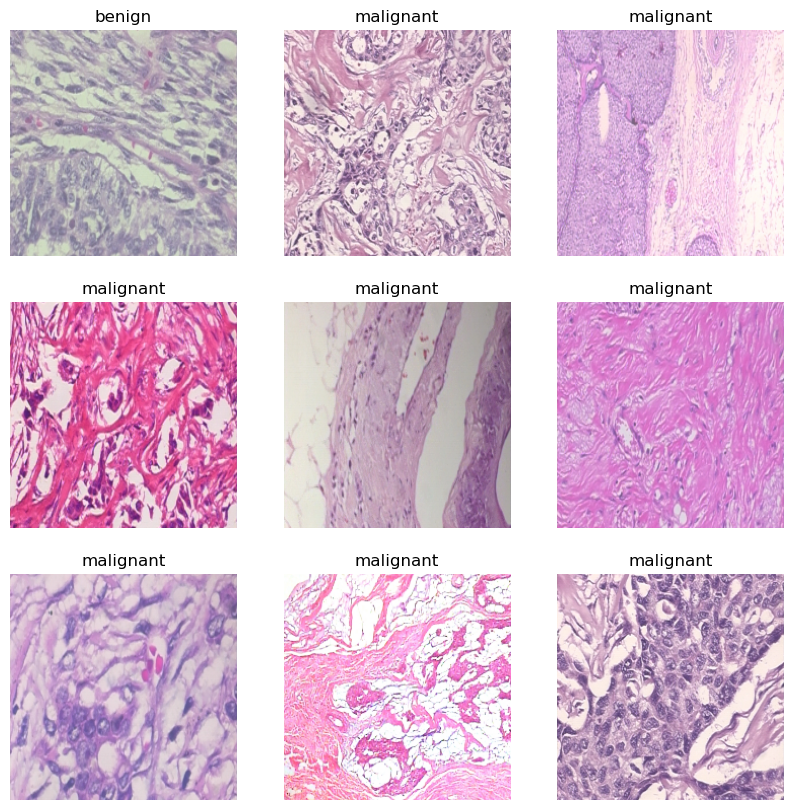

In [77]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [78]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [79]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

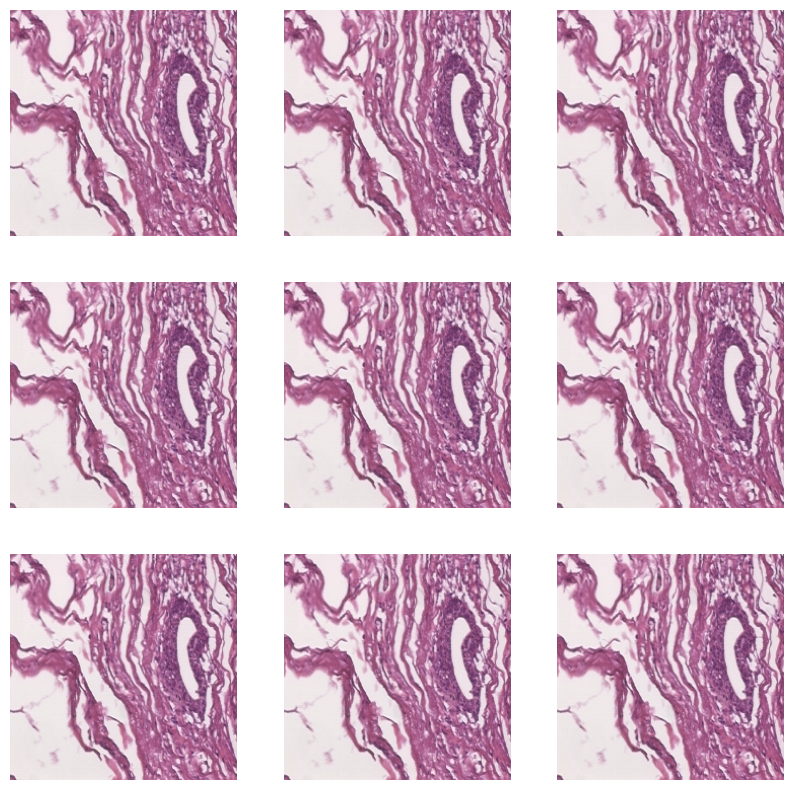

In [80]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [81]:
preprocess_input = tf.keras.applications.densenet.preprocess_input

In [82]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [83]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [84]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1024)


In [85]:
base_model.trainable = False

In [86]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_5[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [87]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


In [88]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [89]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [90]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037

In [91]:
len(model.trainable_variables)

2

In [92]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [93]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [94]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

25/25 [==============================] - 4s 93ms/step - loss: 0.6274 - accuracy: 0.6595


In [95]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.63
initial accuracy: 0.66


In [96]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20


198/198 [==============================] - 39s 171ms/step - loss: 0.5974 - accuracy: 0.6931 - val_loss: 0.5450 - val_accuracy: 0.7190
Epoch 2/20
198/198 [==============================] - 33s 168ms/step - loss: 0.5247 - accuracy: 0.7479 - val_loss: 0.4931 - val_accuracy: 0.7506
Epoch 3/20
198/198 [==============================] - 33s 168ms/step - loss: 0.4768 - accuracy: 0.7844 - val_loss: 0.4615 - val_accuracy: 0.7734
Epoch 4/20
198/198 [==============================] - 33s 168ms/step - loss: 0.4529 - accuracy: 0.7958 - val_loss: 0.4339 - val_accuracy: 0.8025
Epoch 5/20
198/198 [==============================] - 33s 168ms/step - loss: 0.4236 - accuracy: 0.8197 - val_loss: 0.4151 - val_accuracy: 0.8101
Epoch 6/20
198/198 [==============================] - 33s 168ms/step - loss: 0.4055 - accuracy: 0.8295 - val_loss: 0.4016 - val_accuracy: 0.8203
Epoch 7/20
198/198 [==============================] - 34s 168ms/step - loss: 0.3888 - accuracy: 0.8386 - val_loss: 0.3881 - val_accuracy: 0.8

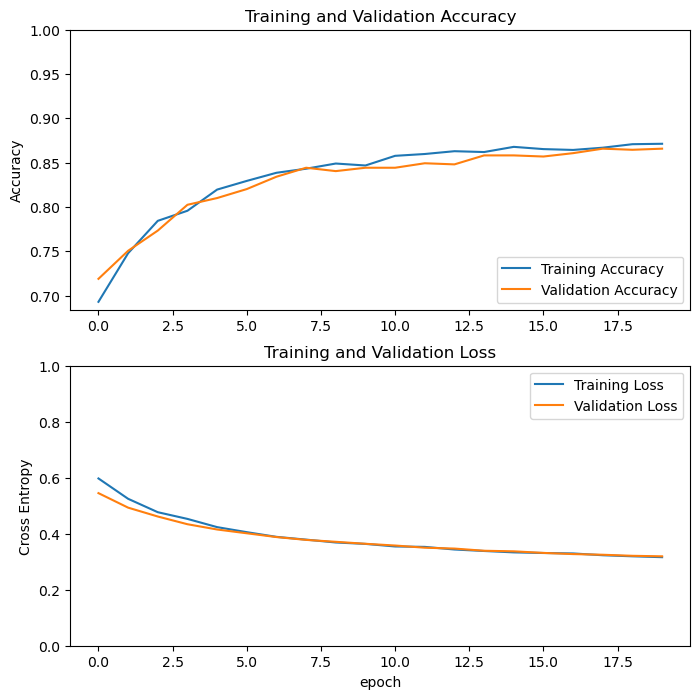

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [98]:
base_model.trainable = True

In [99]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  427


In [100]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [101]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037

In [102]:
len(model.trainable_variables)

196

In [103]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40


198/198 [==============================] - 59s 243ms/step - loss: 0.2710 - accuracy: 0.8941 - val_loss: 0.2595 - val_accuracy: 0.8937
Epoch 21/40
198/198 [==============================] - 49s 247ms/step - loss: 0.2157 - accuracy: 0.9169 - val_loss: 0.2005 - val_accuracy: 0.9278
Epoch 22/40
198/198 [==============================] - 49s 246ms/step - loss: 0.1849 - accuracy: 0.9298 - val_loss: 0.1755 - val_accuracy: 0.9304
Epoch 23/40
198/198 [==============================] - 48s 241ms/step - loss: 0.1606 - accuracy: 0.9390 - val_loss: 0.2237 - val_accuracy: 0.9203
Epoch 24/40
198/198 [==============================] - 48s 241ms/step - loss: 0.1502 - accuracy: 0.9456 - val_loss: 0.1451 - val_accuracy: 0.9544
Epoch 25/40
198/198 [==============================] - 48s 241ms/step - loss: 0.1318 - accuracy: 0.9494 - val_loss: 0.1388 - val_accuracy: 0.9506
Epoch 26/40
198/198 [==============================] - 48s 242ms/step - loss: 0.1174 - accuracy: 0.9534 - val_loss: 0.1390 - val_accurac

In [104]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

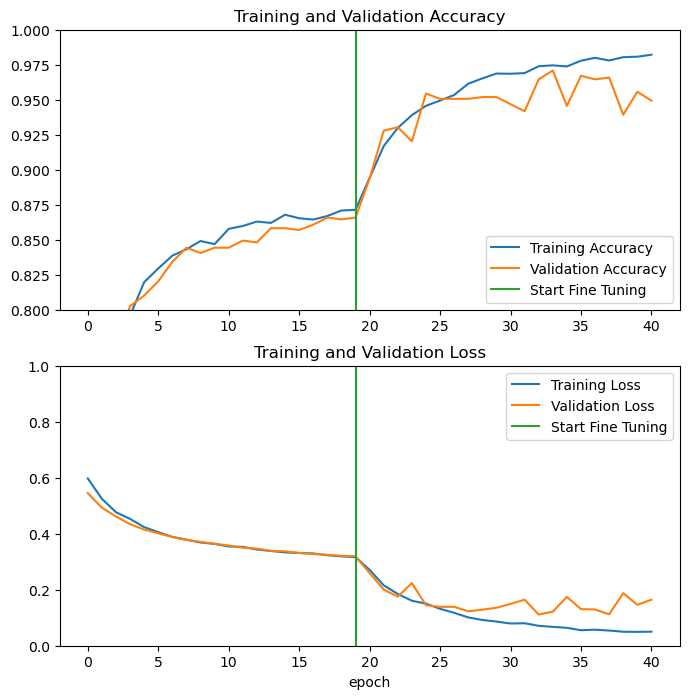

In [105]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [106]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

25/25 [==============================] - 3s 94ms/step - loss: 0.0707 - accuracy: 0.9697
Test accuracy : 0.9696969985961914


Predictions:
 [1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1]
Labels:
 [1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1]


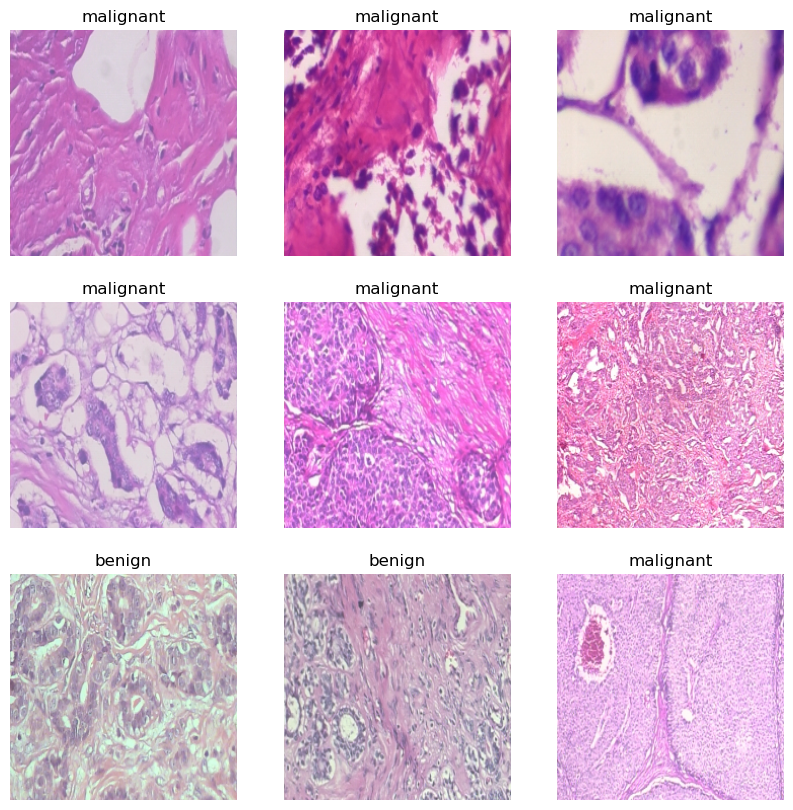

In [107]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [108]:
model.save('')

In [109]:
tf.data.experimental.save(train_dataset, '')
tf.data.experimental.save(validation_dataset, '')
tf.data.experimental.save(test_dataset, '')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.
